# Systematic bias in Monte Carlo median scores

Based on [this SO question](https://stackoverflow.com/questions/72660400/variation-between-montecarlo-mean-score-and-static-lca-score/72662031?noredirect=1#comment128732500_72662031). Reproduce questions results:

In [169]:
import bw2calc as bc
import bw2data as bd
import bw2analyzer as ba
import seaborn as sb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [4]:
bd.projects.set_current('GSA for archetypes')  # Some project with ecoinvent 3.8, any system model

In [6]:
ei = bd.Database('ecoinvent 3.8 cutoff')

In [8]:
cc = ('EF v3.0 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')

In [9]:
act = ei.get(name='battery cell production, Li-ion, NMC111', location='CN')

In [10]:
static = bc.LCA({act: 1}, cc)
static.lci()
static.lcia()
static.score

18.151654396465364

In [152]:
mc = bc.LCA({act: 1}, cc, use_distributions=True)
mc.lci()
mc.lcia()

In [156]:
results = np.array([mc.score for _ in zip(mc, range(50))])

In [157]:
np.mean(results), np.median(results)

(20.56367951612979, 20.70542128862659)

## Make sure our theory on multiplying lognormals is correct

Should be ~1

In [27]:
np.median(np.random.lognormal(size=1000) * np.random.lognormal(size=1000))

0.9986066394872015

## Try building a much smaller system and check behaviour

In [158]:
def build_matrix(a, b, c, d):
    return np.matrix([[a, b], [c, d]])

def build_random_matrix(sigma=0.1):
    b = -1 * np.random.lognormal(mean=np.log(0.1), sigma=sigma)    
    c = -1 * np.random.lognormal(mean=np.log(0.5), sigma=sigma)
    return build_matrix(1, b, c, 1)

def solve_uncertain(sigma=0.1, verbose=False):
    matrix = build_random_matrix(sigma=sigma)
    if verbose:
        print(matrix)
    supply = np.linalg.solve(matrix, np.array([1, 0]))
    if verbose:
        print(supply)
    biosphere = build_matrix(0, np.random.lognormal(mean=np.log(5), sigma=sigma), 0, 0)
    if verbose:
        print(biosphere)
    return (biosphere @ supply).sum()

def solve_certain():
    supply = np.linalg.solve(build_matrix(1, -0.1, -0.5, 1), np.array([1, 0]))
    biosphere = build_matrix(0, 5, 0, 0)
    return (biosphere @ supply).sum()

In [109]:
solve_certain()

2.631578947368421

In a 2x2 matrix with cycles we don't see the same behaviour

In [166]:
np.median([solve_uncertain(sigma=0.1) for _ in range(10000)])

2.6271094851619856

## Do large $\sigma$ values matter?

In [172]:
xs = np.linspace(0.001, 0.75, 8)

In [173]:
ys = [np.median([solve_uncertain(sigma=sigma) for _ in range(10000)]) for sigma in xs]

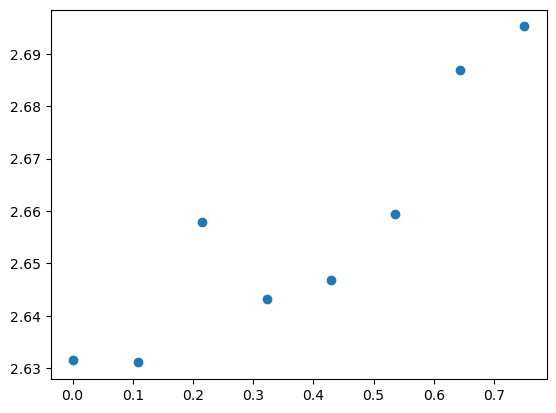

In [174]:
plt.scatter(xs, ys)

Doesn't seem like it, these differences are too small compared to what we see with ecoinvent.

## How big is the bias?

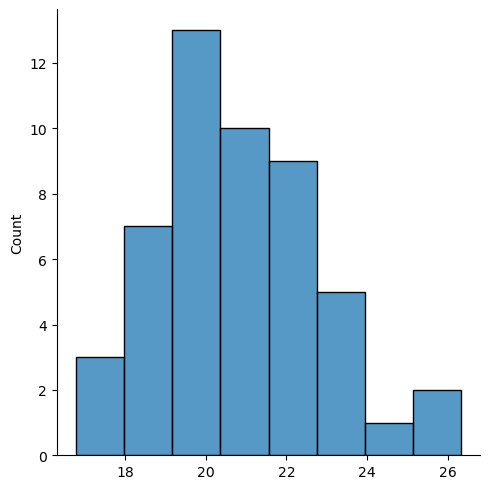

In [148]:
sb.displot(results)

Actually rather substantial...

## What about the other geometric and Gaussian distributions?

Try to remove them.

In [152]:
mc = bc.LCA({act: 1}, cc, use_distributions=True)
mc.lci()
mc.lcia()

In [154]:
for grp_list in mc.technosphere_mm.packages.values():
    for group in grp_list:
        try:
            group.rng.params[group.rng.params['uncertainty_type'] > 2]['uncertainty_type'] = 0
        except AttributeError:
            pass

In [155]:
for grp_list in mc.biosphere_mm.packages.values():
    for group in grp_list:
        try:
            group.rng.params[group.rng.params['uncertainty_type'] > 2]['uncertainty_type'] = 0
        except AttributeError:
            pass

In [156]:
results = np.array([mc.score for _ in zip(mc, range(50))])

Doesn't seem to help.

In [157]:
np.mean(results), np.median(results)

(20.56367951612979, 20.70542128862659)

## Can we find out where the numbers are larger?

In [24]:
ba.utils.print_recursive_calculation(act, cc, max_level=4, use_matrix_values=True, _lca_obj=mc, _total_score=mc.score)

Fraction of score | Absolute score | Amount | Activity
0001 | 21.84 |     1 | 'battery cell production, Li-ion, NMC111' (kilogram, CN, None)
  0.646 | 14.11 | 0.394 | 'market for cathode, NMC111, for Li-ion battery' (kilogram, CN, None)
    0.646 |  14.1 | 0.394 | 'cathode production, NMC111, for Li-ion battery' (kilogram, CN, None)
      0.0104 | 0.2274 | 0.1736 | 'market group for electricity, medium voltage' (kilowatt hour, CN, Non
      0.0193 | 0.4215 | 10.19 | 'market for heat, district or industrial, natural gas' (megajoule, RoW
      0.619 | 13.51 | 0.3743 | 'market for NMC111 oxide' (kilogram, CN, None)
        0.619 | 13.51 | 0.3743 | 'NMC111 oxide production, for Li-ion battery' (kilogram, CN, None)
  0.0789 | 1.722 | 0.2101 | 'market for anode, graphite, for Li-ion battery' (kilogram, CN, None)
    0.0787 |  1.72 | 0.2101 | 'anode production, graphite, for Li-ion battery' (kilogram, CN, None)
      0.0666 | 1.455 | 0.1975 | 'market for synthetic graphite, battery grade' (ki

In [25]:
ba.utils.print_recursive_calculation(act, cc, max_level=4)

Fraction of score | Absolute score | Amount | Activity
0001 | 18.15 |     1 | 'battery cell production, Li-ion, NMC111' (kilogram, CN, None)
  0.668 | 12.12 |  0.41 | 'market for cathode, NMC111, for Li-ion battery' (kilogram, CN, None)
    0.667 | 12.11 |  0.41 | 'cathode production, NMC111, for Li-ion battery' (kilogram, CN, None)
      0.0106 | 0.1916 | 0.1806 | 'market group for electricity, medium voltage' (kilowatt hour, CN, Non
      0.0226 | 0.4107 |  10.6 | 'market for heat, district or industrial, natural gas' (megajoule, RoW
      0.622 | 11.29 | 0.3895 | 'market for NMC111 oxide' (kilogram, CN, None)
        0.622 | 11.29 | 0.3895 | 'NMC111 oxide production, for Li-ion battery' (kilogram, CN, None)
  0.0697 | 1.265 |   0.2 | 'market for anode, graphite, for Li-ion battery' (kilogram, CN, None)
    0.0696 | 1.263 |   0.2 | 'anode production, graphite, for Li-ion battery' (kilogram, CN, None)
      0.0583 | 1.059 | 0.188 | 'market for synthetic graphite, battery grade' (kilog

Not immediately, and this is only one iteration.